# LangGraph doing a web search plus sentiment analysis

* Sign up to: https://app.tavily.com/home
* Tavily search tool: https://python.langchain.com/docs/integrations/tools/tavily_search
* LangGraph persistence: https://langchain-ai.github.io/langgraph/concepts/persistence/

In [2]:
%%capture --no-stderr
%pip install langchain langchain-openai langchain_experimental python-dotenv matplotlib numpy pandas langgraph langchain-community langchain_tavily

In [3]:
import json
from dotenv import load_dotenv

load_dotenv()

def pp(data):
    print(json.dumps(data, indent=2, default=str))


## Tavily Search Tool

In [4]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=5,
    topic="general", # Can be "general", "news", or "finance"
    # include_answer=False,
    # include_raw_content=False,
    include_images=False,
    include_image_descriptions=False,
    search_depth="basic",
    time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

response = tavily_search.invoke("Is people buying Bitcoin on the last month?")


In [5]:
response['results']

[{'url': 'https://www.reddit.com/r/Bitcoin/',
  'title': 'Bitcoin - The Currency of the Internet',
  'content': 'Bitcoin is up 80% over the past year, more than any other major asset.',
  'score': 0.98571,
  'raw_content': None},
 {'url': 'https://www.youtube.com/watch?v=nf8ssn7Clp8',
  'title': 'Bitcoin Tumbles to $115K! Can The Rally Continue?',
  'content': "#Bitcoin #Crypto #Finance Is the Bitcoin cycle top already in, or are we gearing up for another leg higher? Today's livestream breaks down the latest",
  'score': 0.98352,
  'raw_content': None},
 {'url': 'https://www.youtube.com/watch?v=w9s7Ukrxcpk',
  'title': 'BTC About To Break? Sol, LINK & TOP ETH Tokens ...',
  'content': "BTC Hits ATH, Then Crashes | SOL Struggles | ETH Ecosystem Heating Up | Fed, SEC & DOGE ETF Bitcoin's wild ride continues — blasting past $100K to a new",
  'score': 0.9788,
  'raw_content': None},
 {'url': 'https://pintu.co.id/en/news/195423-crypto-market-correction-bitcoin-price-plunges-to-115000-what-

## LangGraph Basics

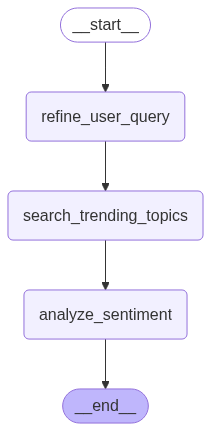

In [ ]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-5-nano")

class TypedDictState(TypedDict):
    user_query: str
    refined_query: str
    trending_topics: str
    sentiment_analysis: str

def refine_user_query(state: TypedDictState) -> TypedDictState:
    user_query = state['user_query']

    prompt = f"""
    Given the user query, your job is to rewrite it to make it more specific and clear.

    User query: {user_query}

    Revised query:"""

    response = llm.invoke(prompt)

    return { "refined_query": response.content.strip() }

def search_trending_topics(state: TypedDictState) -> TypedDictState:
    refined_query = state['refined_query']

    prompt = f"""
    Given the refined user query, your job is to search for trending topics related to it.

    Refined query: {refined_query}

    Trending topics:"""

    response = llm.bind_tools([tavily_search]).invoke(prompt)

    return { "trending_topics": response.content.strip() }

def analyze_sentiment(state: TypedDictState) -> TypedDictState:

    trending_topics = state['trending_topics']

    prompt = f"""
    Given the trending topics, your job is to analyze their sentiment.

    Trending topics: {trending_topics}

    Sentiment analysis:"""

    response = llm.invoke(prompt)

    return { "sentiment_analysis": response.content.strip() }

builder = StateGraph(TypedDictState)

builder.add_node("refine_user_query", refine_user_query)
builder.add_node("search_trending_topics", search_trending_topics)
builder.add_node("analyze_sentiment", analyze_sentiment)

builder.add_edge(START, "refine_user_query")
builder.add_edge("refine_user_query", "search_trending_topics")
builder.add_edge("search_trending_topics", "analyze_sentiment")
builder.add_edge("analyze_sentiment", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
initial_state : TypedDictState = {
    "user_query": "Is people buying ETH on the last month?",
    "refined_query": "",
    "trending_topics": "",
    "sentiment_analysis": ""
}

state = graph.invoke(input=initial_state)

In [8]:
state

{'user_query': 'Is people buying ETH on the last month?',
 'refined_query': 'Revised query: What was the total buy volume of Ethereum (ETH) on major exchanges in the last 30 days, and how did it compare to the previous 30 days?',
 'trending_topics': '',
 'sentiment_analysis': 'I don’t have the actual trending topics yet. Please provide the list of topics you want analyzed (and optionally a few recent posts for each topic). I’ll return a sentiment analysis for each.\n\nWhat I’ll deliver for each topic:\n- Topic name\n- Overall sentiment: Positive / Neutral / Negative\n- Polarity score: -1.0 (very negative) to +1.0 (very positive)\n- Confidence (how sure the analysis is)\n- Top sentiment drivers (keywords or themes pulling the sentiment)\n- 2–3 representative posts or quotes illustrating the sentiment\n- Quick notes on any caveats (e.g., mixed feelings, sarcasm, topic ambiguity)\n\nOptional: specify the time window (e.g., past 24 hours, past week) and sources (Twitter/X, Reddit, news, fo

In [9]:
from IPython.display import Markdown, display

display(Markdown(f"**Sentiment Analysis:**\n\n{state['sentiment_analysis']}"))


**Sentiment Analysis:**

I don’t have the actual trending topics yet. Please provide the list of topics you want analyzed (and optionally a few recent posts for each topic). I’ll return a sentiment analysis for each.

What I’ll deliver for each topic:
- Topic name
- Overall sentiment: Positive / Neutral / Negative
- Polarity score: -1.0 (very negative) to +1.0 (very positive)
- Confidence (how sure the analysis is)
- Top sentiment drivers (keywords or themes pulling the sentiment)
- 2–3 representative posts or quotes illustrating the sentiment
- Quick notes on any caveats (e.g., mixed feelings, sarcasm, topic ambiguity)

Optional: specify the time window (e.g., past 24 hours, past week) and sources (Twitter/X, Reddit, news, forums).

If you’d like, I can also show a quick example with placeholder topics just to demonstrate the format. For example:
- Topic: “Product X launch”
  - Overall sentiment: Positive
  - Polarity score: +0.62
  - Confidence: 0.78
  - Top drivers: “new features,” “pricing,” “availability”
  - Quotes: “Impressive features at this price,” “waiting for reviews”
  - Notes: Some sarcasm around launch delays noted

Please paste the trending topics (and any sample posts), and I’ll analyze them.

## Ejecución secuencial utilizando iteradores (aka stream)

In [10]:
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import InMemorySaver

initial_state : TypedDictState = {
    "user_query": "Is people buying ETH on the last month?",
    "refined_query": "",
    "trending_topics": "",
    "sentiment_analysis": ""
}

# Configuración para poder disponer del estado de la ejecución
config : RunnableConfig = {
    "configurable": {
        # Esto funciona como una key para la corriga que voy a monitorear
        "thread_id": "web_search_run_1234",
    }
}

# Funciona como un logger en memoria
memory = InMemorySaver()

# Conecto el checkpointer al grafo
graph = builder.compile(checkpointer=memory)

# stream_mode disponibles => https://langchain-ai.github.io/langgraph/how-tos/streaming/
iter = graph.stream(initial_state, config=config, debug=True, stream_mode="updates")

for state in iter:
    print(state)


[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query': '', 'trending_topics': '', 'sentiment_analysis': ''}
[updates] {'refine_user_query': {'refined_query': 'Revised query: What has been the buying activity for Ethereum (ETH) over the past 30 days?'}}
{'refine_user_query': {'refined_query': 'Revised query: What has been the buying activity for Ethereum (ETH) over the past 30 days?'}}
[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query': 'Revised query: What has been the buying activity for Ethereum (ETH) over the past 30 days?', 'trending_topics': '', 'sentiment_analysis': ''}
[updates] {'search_trending_topics': {'trending_topics': ''}}
{'search_trending_topics': {'trending_topics': ''}}
[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query': 'Revised query: What has been the buying activity for Ethereum (ETH) over the past 30 days?', 'trending_topics': '', 'sentiment_analysis': ''}
[updates] {'ana

In [11]:
initial_state : TypedDictState = {
    "user_query": "Is people buying ETH on the last month?",
    "refined_query": "",
    "trending_topics": "",
    "sentiment_analysis": ""
}

iter = graph.stream(initial_state, interrupt_before="search_trending_topics", debug=True, config=config, stream_mode="updates")

for state in iter:
    print(state)

[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query': '', 'trending_topics': '', 'sentiment_analysis': ''}
[updates] {'refine_user_query': {'refined_query': 'Have people been buying Ethereum (ETH) in the past month?'}}
{'refine_user_query': {'refined_query': 'Have people been buying Ethereum (ETH) in the past month?'}}
[values] {'user_query': 'Is people buying ETH on the last month?', 'refined_query': 'Have people been buying Ethereum (ETH) in the past month?', 'trending_topics': '', 'sentiment_analysis': ''}
[updates] {'__interrupt__': ()}
{'__interrupt__': ()}


In [12]:
snapshot = graph.get_state(config=config)

In [13]:
pp(snapshot.values)

{
  "user_query": "Is people buying ETH on the last month?",
  "refined_query": "Have people been buying Ethereum (ETH) in the past month?",
  "trending_topics": "",
  "sentiment_analysis": ""
}


In [14]:
graph.nodes

{'__start__': <langgraph.pregel._read.PregelNode at 0x109511070>,
 'refine_user_query': <langgraph.pregel._read.PregelNode at 0x109511130>,
 'search_trending_topics': <langgraph.pregel._read.PregelNode at 0x1095110a0>,
 'analyze_sentiment': <langgraph.pregel._read.PregelNode at 0x1095111f0>}

In [15]:
next_state = graph.nodes['search_trending_topics'].invoke(snapshot.values)

In [16]:
next_state

{'trending_topics': ''}

In [17]:
def search_trending_topics(state: TypedDictState) -> TypedDictState:
    refined_query = state['refined_query']

    prompt = f"""
    Given the refined user query, your job is to search for trending topics related to it.

    Refined query: {refined_query}

    Trending topics:"""

    response = llm.bind_tools([tavily_search]).invoke(prompt)

    pp(response.tool_calls)

    return { "trending_topics": response.content.strip() }

search_trending_topics(snapshot.values)

[
  {
    "name": "tavily_search",
    "args": {
      "query": "Ethereum net inflows to exchanges last 30 days",
      "search_depth": "advanced",
      "time_range": "month"
    },
    "id": "call_Z2xwYisVY2Ax1GYFRXIKtMTt",
    "type": "tool_call"
  },
  {
    "name": "tavily_search",
    "args": {
      "query": "ETH buying activity last 30 days",
      "search_depth": "advanced",
      "time_range": "month"
    },
    "id": "call_AlrPeUkNkHIiPmIRbhk0LhEI",
    "type": "tool_call"
  },
  {
    "name": "tavily_search",
    "args": {
      "query": "Ethereum wallet activity last month trends",
      "search_depth": "advanced",
      "time_range": "month"
    },
    "id": "call_NSiPl8YrnWgKTHwYi0S3nuyN",
    "type": "tool_call"
  },
  {
    "name": "tavily_search",
    "args": {
      "query": "ETH price vs. on-chain metrics last 30 days",
      "search_depth": "advanced",
      "time_range": "month"
    },
    "id": "call_Rbd0he8eNxgN0GvDAWjbUQi6",
    "type": "tool_call"
  }
]


{'trending_topics': ''}

# Quien ejecuta la Tool Call?